In [17]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
import os
from sklearn.model_selection import train_test_split

## Pre-Processing Filters

In [18]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

# Filter parameters
fps = 256  # sampling frequency
cutoff_high = 6  # cutoff frequency of the high-pass filter
cutoff_low = 50  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency).  It represents the highest frequency that can be accurately represented in a discrete-time signal.

In [19]:
master_data = []
master_labels = []

electrode_id = 6 # To only get Oz

labels = [9.25, 11.25, 13.25, 14.25]
stimulus_id = [0, 1, 2, 8]

for subject in range(1, 11):
    mat = sio.loadmat(f'Data\\data\\s{subject}.mat')
    subject_eeg_data = mat["eeg"]
    # 1st dim: 12   -- target
    # 2nd dim: 8    -- channels
    # 3rd dim: 1114 -- timepoints
    # 4th dim: 15   -- trials

    # Doing just 9 Hz, 11 Hz, 13 Hz, 14 Hz
    # Doing just Oz electrode (index 6)

    # Four classes
    for i in range(4):

        # Cycle each through trial in the class
        for j in range(15):

            # Temporary array to hold epoch
            temp_epoch = np.array(subject_eeg_data[stimulus_id[i], electrode_id, 38:, j]).flatten()

            # apply the band-pass filter
            temp_epoch = butter_highpass_filter(
                data=temp_epoch,
                cutoff=cutoff_high,
                nyq=nyq,
                order=4)

            temp_epoch = butter_lowpass_filter(
                data=temp_epoch,
                cutoff=cutoff_low,
                nyq=nyq,
                order=4)

            # Append the epoch data and target label
            master_data.append(temp_epoch)
            
            label = 0
            if labels[i] == 9.25:
                label = 0
            elif labels[i] == 11.25:
                label = 1
            elif labels[i] == 13.25:
                label = 2
            elif labels[i] == 14.25:
                label = 3

            master_labels.append(label)

master_data = np.array(master_data)
master_labels = np.array(master_labels)

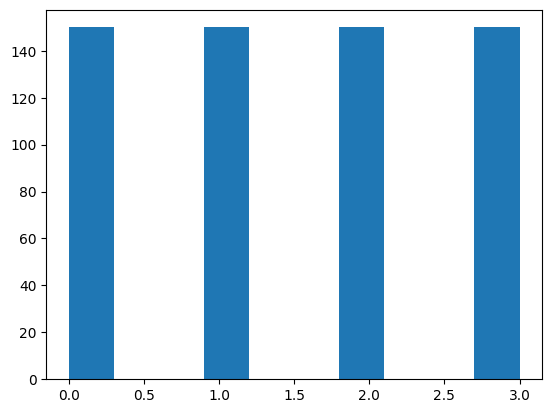

In [20]:
plt.hist(master_labels)
plt.show()

Train: (419, 1076), (419,)
Validation: (91, 1076), (91,)
Test: (90, 1076), (90,)


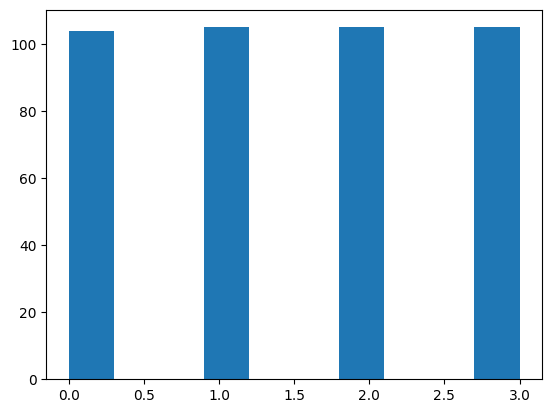

In [21]:
# Train-test split (85% train_val, 15% test)
epochs_train_val, epochs_test, labels_train_val, labels_test = train_test_split(
    master_data, master_labels, test_size=0.15, random_state=42, stratify=master_labels
)

# Train-validation split (from train_val)
epochs_train, epochs_val, labels_train, labels_val = train_test_split(
    epochs_train_val, labels_train_val, test_size=0.1765, random_state=42, stratify=labels_train_val
)  # 0.1765 ≈ 15% of 85%

# Check sizes
print(f"Train: {epochs_train.shape}, {labels_train.shape}")
print(f"Validation: {epochs_val.shape}, {labels_val.shape}")
print(f"Test: {epochs_test.shape}, {labels_test.shape}")

plt.hist(labels_train)
plt.show()


In [22]:
output_dir = "eeg_dataset"
os.makedirs(output_dir, exist_ok=True)

# Save splits
np.save(os.path.join(output_dir, "train_epochs.npy"), epochs_train)
np.save(os.path.join(output_dir, "train_labels.npy"), labels_train)
np.save(os.path.join(output_dir, "val_epochs.npy"), epochs_val)
np.save(os.path.join(output_dir, "val_labels.npy"), labels_val)
np.save(os.path.join(output_dir, "test_epochs.npy"), epochs_test)
np.save(os.path.join(output_dir, "test_labels.npy"), labels_test)

In [23]:
print(len(master_data[0]))

1076
